In [1]:
import pandas as pd
import re
from re import compile, search
from os.path import join

import warnings
warnings.filterwarnings('ignore')

### Import raw data from crawler

In [2]:
file_name = 'sample_100_pages.json'
df_sample = pd.read_json(join('..', 'data', 'crawler', file_name))

### NER extraction

#### Objects with structured description

In [3]:
regexps = {
    'name': compile('име обект: (?P<name>.*?) вид обект'),
    'category': compile('вид обект: (?P<category>.*?) град'),
    'city': compile('град: (?P<city>.*?) адрес'),
    'address': compile('адрес: (?P<address>.*?) описание')
}

def match(prop, text):
    m = regexps[prop].search(text)
    if m is not None:
        return m.group(prop).strip()
    else:
        return None

In [4]:
df_sample['matched_name'] = df_sample['description'].apply(lambda x: match('name', x))
df_sample['matched_category'] = df_sample['description'].apply(lambda x: match('category', x))
df_sample['matched_city'] = df_sample['description'].apply(lambda x: match('city', x))
df_sample['matched_address'] = df_sample['description'].apply(lambda x: match('address', x))

In [5]:
df_sample['matched_name'].count()

883

In [6]:
df_sample['matched_city'].count()

885

In [7]:
df_sample['matched_address'].count()

879

In [8]:
df_sample['matched_category'].count()

883

#### Categories based on matched_category

In [9]:
categories = list(filter(lambda x: x is not None, df_sample['matched_category'].unique()))

Parsing to get set of unique categories

In [10]:
def parse_category(category):
    splitted = re.split(r'[-\\\/,]', category)
    return [w.strip().lower() for w in splitted]

def flatten(l):
    return sum(l, [])

all_cats = flatten([ parse_category(category) for category in categories])
unique_cats = set(all_cats)
cat_group = "|".join(unique_cats)

#### Objects with non structured description

In [11]:
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.tag import pos_tag, RegexpTagger
from nltk.chunk.regexp import RegexpChunkParser, RegexpChunkRule
from nltk.tree import Tree

Custom pos-tags

In [12]:
regexp_tagger = RegexpTagger([
    ("^{}$".format(cat_group), 'PLACE_MARKER'),
    (r'^[,]$', 'DT'),
    (r'^в$', 'BEG'),
    (r'^[A-Za-z0-9 &]+$', 'LATIN_WORD'),
    (r'^[а-яА-Я0-9 &]+$', 'CYRILLIC_WORD')
])

Tokenize with word_tokenize and TweetTokenizer

In [13]:
tweet_token = TweetTokenizer().tokenize

def tokenize(title, tokenizer):
    words = tokenizer(title)
    tokens = regexp_tagger.tag(words)
    return [token for token in tokens if token[1] is not None]

Chunkparser to extract name.

In [14]:
chuncker = RegexpChunkParser([
        RegexpChunkRule.fromstring(r'{<BEG> (<LATIN_WORD>|<CYRILLIC_WORD>)+ <PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)* (?=<DT>|<BEG>)*}'),
        RegexpChunkRule.fromstring(r'{(<PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)+)+ <PLACE_MARKER>* (?=<DT>|<BEG>)*}'),
        RegexpChunkRule.fromstring(r'{<PLACE_MARKER>+ (<LATIN_WORD>|<CYRILLIC_WORD>)+ (?=<DT>|<BEG>)*}'),
    ],
    chunk_label='Name'
)


def get_words(tree):
    return [word for word in tree.leaves()]

def find_name(title, tokenizer, visual=False):
    if title is "":
        return None
    
    title = title.lower()
    tokens = tokenize(title, tokenizer)
    tree = chuncker.parse(tokens)
    chunk_tree = [t.leaves() for t in tree if type(t) is Tree]
    flattened = sum(chunk_tree, [])
    filtered = [(w.strip(), m) for w, m in flattened if w != "в"]
    if visual:
        return tree
    return filtered

#### Examples

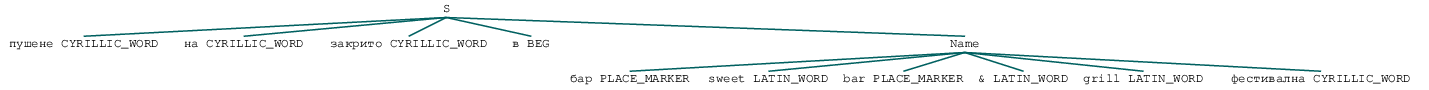

In [15]:
tree = find_name('Пушене на закрито в бар Sweet bar&grill Фестивална', tweet_token, visual=True)

tree

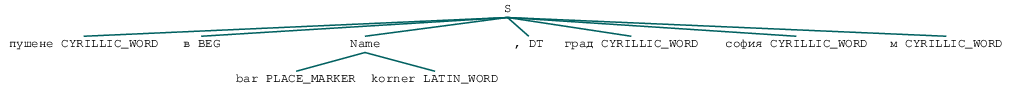

In [16]:
tree = find_name('Пушене в Bar "Korner", град София (м)', tweet_token, visual=True)

tree

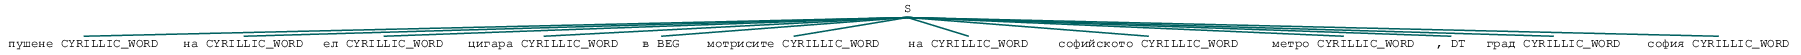

In [17]:
tree = find_name('Пушене на ел.цигара в мотрисите на Софийското метро, град София', tweet_token, visual=True)

tree

#### Apply functions to extract name for all objects

In [18]:
df_sample['matched_title'] = df_sample['title'].apply(lambda x: find_name(x, tweet_token))

In [19]:
df_sample['matched_title_2'] = df_sample['title'].apply(lambda x: find_name(x, word_tokenize))

In [20]:
def concat_title(tuples):
    if tuples == [] or tuples is None:
        return None
    name = []
    for word, marker in tuples:
        name.append(word)
        
    return ' '.join(name)

In [21]:
df_sample['matched_title_str'] = df_sample['matched_title'].apply(concat_title)

In [22]:
df_sample['matched_title_2_str'] = df_sample['matched_title_2'].apply(concat_title)

### Final DF and Export

In [23]:
df_sample

,categories,date,description,files,id,location,title,matched_name,matched_category,matched_city,matched_address,matched_title,matched_title_2,matched_title_str,matched_title_2_str
0,[заведение за хранене и развлечение],09:30 Mar 30 2018,"В сладкарница Малинка, пушат навсякъде! * Сигн...",[{'url': 'https://bezdim.org/signali/media/upl...,10244,"град София, кв. Младост, сп. Окръжна болница, ...","Пушене в сладкарница Малинка, град София",None,None,None,None,"[(сладкарница, PLACE_MARKER), (малинка, CYRILL...","[(сладкарница, PLACE_MARKER), (малинка, CYRILL...",сладкарница малинка,сладкарница малинка
1,[заведение за хранене и развлечение],02:13 Mar 31 2018,В Глори бар и грил се пуши дори през деня. * С...,[{'url': 'https://bezdim.org/signali/media/upl...,10249,"град София, ул. Пирински проход 24 А","Неспазване на забраната за тютюнопушене, град ...",None,None,None,None,[],[],None,None
2,[заведение за хранене и развлечение],05:00 Jul 6 2018,име обект: Mr. Pizza вид обект: Ресторант град...,[{'url': 'https://bezdim.org/signali/media/upl...,10355,"град София , бул. ""Черни връх"" № 100","Пушене в ресторант ""Mr. Pizza"", град София (м)",Mr. Pizza,Ресторант,София,"Мол Парадайз, бул. ""Черни връх"" № 100","[(ресторант, PLACE_MARKER), (mr, LATIN_WORD), ...","[(ресторант, PLACE_MARKER), (pizza, LATIN_WORD)]",ресторант mr pizza,ресторант pizza
3,[заведение за хранене и развлечение],01:50 Dec 18 2018,име обект: Галерия вид обект: рсторант град: К...,[{'url': 'https://bezdim.org/signali/media/upl...,10471,"град Кюстендил, ул. ""Д. Димитрий"" 9","Пушене в рсторант ""Галерия"", град Кюстендил (м)",Галерия,рсторант,Кюстендил,"ул.""Д.Димитрий"" 9","[(рсторант, PLACE_MARKER), (галерия, CYRILLIC_...","[(рсторант, PLACE_MARKER), (галерия, CYRILLIC_...",рсторант галерия,рсторант галерия
4,[заведение за хранене и развлечение],09:23 Dec 17 2018,"Понеделник вечерта, седнах да вечерям в SARAY ...",[{'url': 'https://bezdim.org/signali/media/upl...,10469,"град София, Дружба 2, ул. Копенхаген № 17","Пушене в заведение SARAY turkish restaurant, г...",None,None,None,None,"[(заведение, PLACE_MARKER), (saray, LATIN_WORD...","[(заведение, PLACE_MARKER), (saray, LATIN_WORD...",заведение saray turkish restaurant,заведение saray turkish restaurant
5,[заведение за хранене и развлечение],00:43 Dec 19 2018,име обект: Casita food & wine вид обект: Ресто...,[{'url': 'https://bezdim.org/signali/media/upl...,10472,"град София, ул. Доспат 66","Пушене в ресторант ""Casita food & wine"", град ...",Casita food & wine,Ресторант,София,Ул. Доспат 66,"[(ресторант, PLACE_MARKER), (casita, LATIN_WOR...","[(ресторант, PLACE_MARKER), (casita, LATIN_WOR...",ресторант casita food & wine,ресторант casita food & wine
6,[заведение за хранене и развлечение],08:44 Dec 20 2018,"В кафе бар ""Табакера"" се пуши всяка вечер,вътр...",[{'url': 'https://bezdim.org/signali/media/upl...,10474,"град София, ж.к. Люлин, ул. Тодор Влайков 27","Пуши се в кафе бар ""Табакера"", град София",None,None,None,None,"[(кафе, PLACE_MARKER), (бар, PLACE_MARKER), (т...","[(кафе, PLACE_MARKER), (бар, PLACE_MARKER), (т...",кафе бар табакера,кафе бар табакера
7,[заведение за хранене и развлечение],00:40 Dec 20 2018,Тютюнопушене в заведението на обяд??!! * Сигна...,[{'url': 'https://bezdim.org/signali/media/upl...,10473,"град София, ул. Алабин 35","Пушене в ресторант ""Етно"", град София",None,None,None,None,"[(ресторант, PLACE_MARKER), (етно, CYRILLIC_WO...","[(ресторант, PLACE_MARKER), (етно, CYRILLIC_WO...",ресторант етно,ресторант етно
8,[заведение за хранене и развлечение],08:45 May 3 2018,име обект: На улицата вид обект: Ресторант гра...,[{'url': 'https://bezdim.org/signali/media/upl...,10319,"град София, бул. Алвксандър Пушкин 38","Пушене в ресторант ""На улицата"", град София (м)",На улицата,Ресторант,София,бул. Алвксандър Пушкин 38,"[(ресторант, PLACE_MARKER), (на, CYRILLIC_WORD...","[(ресторант, PLACE_MARKER), (на, CYRILLIC_WORD...",ресторант на улицата,ресторант на улицата
9,[заведение за хранене и развлеч

In [24]:
df_sample.to_json(join('..', 'data', 'ner', 'sample_100_pages_names_tokens.json'))

In [25]:
pd.read_json(join('..', 'data', 'ner', 'sample_100_pages_names_tokens.json')).count()

categories             3000
date                   3000
description            3000
files                  3000
id                     3000
location               3000
title                  3000
matched_name            883
matched_category        883
matched_city            885
matched_address         879
matched_title          2989
matched_title_2        2989
matched_title_str      2271
matched_title_2_str    2268
dtype: int64